### Train `Snapbot` to walk using DLPG

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from mujoco_parser import MuJoCoParserClass
from pid import PID_ControllerClass
from grp import GaussianRandomPathClass
from dlpg import DeepLatentPolicyGradientClass
from snapbot_util import *
from util import *
print ("Done.")

Done.


### Hyperparameters

In [2]:
# Basic configuration
n_update              = 1000 # total number of updates (outer loop)
n_rollout_per_update  = 5    # number of rollouts per update
dur_sec               = 1.0  # duration (sec) of a trajectory
n_traj_repeat         = 5
print_every_update    = 10
evaluate_every_update = 100
save_every_update     = 100
n_rollout_per_eval    = 2
DO_RENDER_WHILE_EVAL  = False
# DLPG configuration
n_anchor              = 20    # number of anchors
n_iter_per_update     = 100   # number of iterations per update
n_dpp_subset          = 32
batch_size            = 8
Q_RENORMALIZE         = True  # renormalize Q within batch
# Reward
fwd_gain              = 1.0
side_penalty          = 1.0
rot_penalty           = 2.0
print ("Done.")

Done.


In [3]:
def get_snapbot_reward(xyrad_list,fwd_gain=1.0,side_penalty=0.5,rot_penalty=0.5):
    """
        Sequence of (x,y,rad)
    """
    x_diff_mm = (xyrad_list[-1,0]-xyrad_list[0,0])*1000.0
    y_diff_mm = (xyrad_list[-1,1]-xyrad_list[0,1])*1000.0
    deg_diff  = (xyrad_list[-1,2]-xyrad_list[0,2])*180/np.pi
    reward    = fwd_gain*x_diff_mm-side_penalty*np.abs(y_diff_mm)-rot_penalty*np.abs(deg_diff)
    return reward
print ("Done.")

Done.


### Instantiate

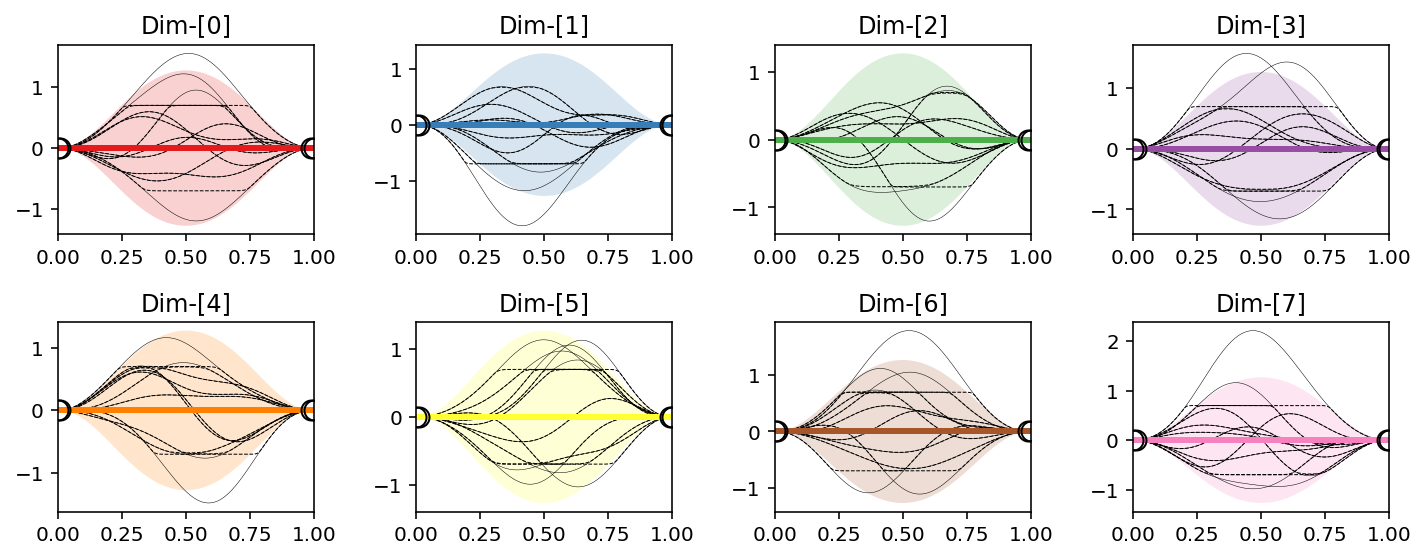

In [4]:
env = MuJoCoParserClass(name='Snapbot',rel_xml_path='../asset/snapbot/robot_4_1245.xml',VERBOSE=False)
PID = PID_ControllerClass(
    name    = 'PID',
    k_p     = 50.0, # default: 20.0
    k_i     = 0.1,
    k_d     = 1.0,
    dim     = env.n_actuator,
    out_min = env.torque_range[:,0],
    out_max = env.torque_range[:,1])
GRP_prior = GaussianRandomPathClass(name='GRP Prior',kernel=kernel_levse)
GRP_prior.set_prior(q_init=np.zeros(env.n_actuator),dur_sec=dur_sec,HZ=env.HZ,hyp={'g':1/2,'l':1/4,'w':1e-8})
GRP_prior.plot(figsize=(10,4),subplot_rc=(2,4),tfs=12,
               ss_x_min=-40*np.pi/180*np.ones(8),ss_x_max=40*np.pi/180*np.ones(8),ss_margin=5*np.pi/180)
GRP_posterior = GaussianRandomPathClass(name='GRP Posterior',kernel=kernel_levse)
ss_range  = 45*np.pi/180*np.concatenate((-np.ones((env.n_actuator,1)),np.ones((env.n_actuator,1))),axis=1)
ss_margin = 5.0*np.pi/180
DLPG = DeepLatentPolicyGradientClass(
    name='U-DLPG-SNAPBOT',x_dim=env.n_actuator*n_anchor,c_dim=0,z_dim=2,h_dims=[128,128],
    actv_enc=torch.nn.LeakyReLU(),actv_dec=torch.nn.LeakyReLU(),actv_q=torch.nn.Softplus(),
    actv_out=None,var_max=0.1,device='cpu')
optm = torch.optim.Adam(params=DLPG.parameters(),lr=0.001,betas=(0.9,0.99),eps=1e-4)

### Train

[0/1000] wall:[1.26]sec. [5] rollouts. Total loss:[0.449] (recon:[0.426] kl:[0.023])


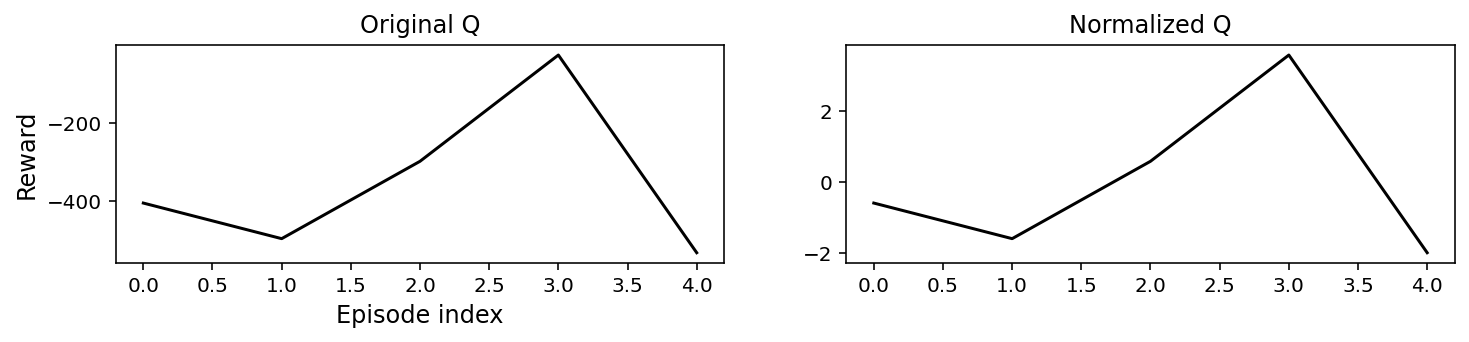

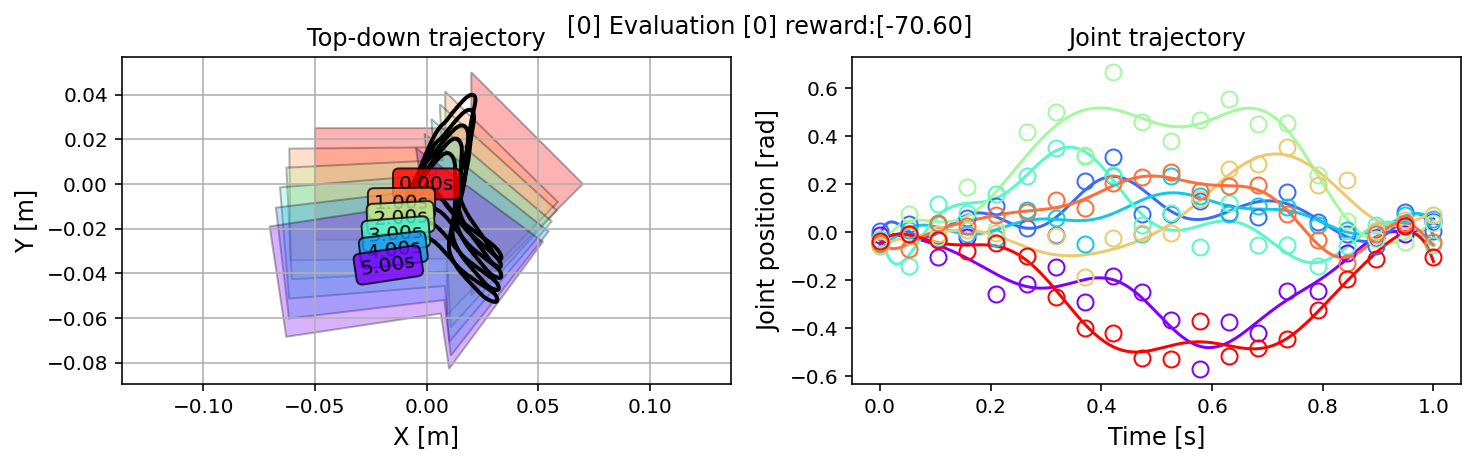

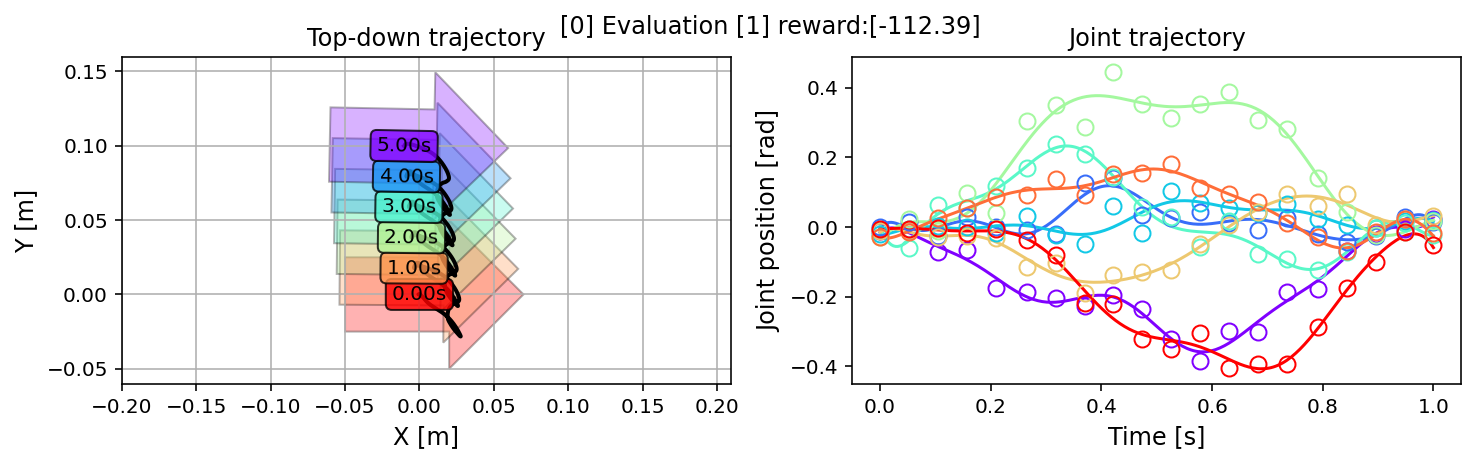

  [0/1000][Eval] reward_avg:[-91.49]
[../weight/U-DLPG-SNAPBOT/wb_0000.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0000.pickle] saved.
[10/1000] wall:[14.14]sec. [55] rollouts. Total loss:[2.404] (recon:[2.301] kl:[0.103])
[20/1000] wall:[26.04]sec. [105] rollouts. Total loss:[2.767] (recon:[2.674] kl:[0.094])
[30/1000] wall:[37.86]sec. [155] rollouts. Total loss:[2.386] (recon:[2.266] kl:[0.120])
[40/1000] wall:[49.69]sec. [205] rollouts. Total loss:[1.957] (recon:[1.852] kl:[0.105])
[50/1000] wall:[61.74]sec. [255] rollouts. Total loss:[1.696] (recon:[1.598] kl:[0.098])
[60/1000] wall:[73.79]sec. [305] rollouts. Total loss:[1.804] (recon:[1.711] kl:[0.093])
[70/1000] wall:[85.86]sec. [355] rollouts. Total loss:[1.576] (recon:[1.484] kl:[0.092])
[80/1000] wall:[97.90]sec. [405] rollouts. Total loss:[1.321] (recon:[1.235] kl:[0.087])
[90/1000] wall:[109.99]sec. [455] rollouts. Total loss:[1.022] (recon:[0.933] kl:[0.090])
[100/1000] wall:[122.05]sec. [505] rollouts. Total loss:[1.028] (

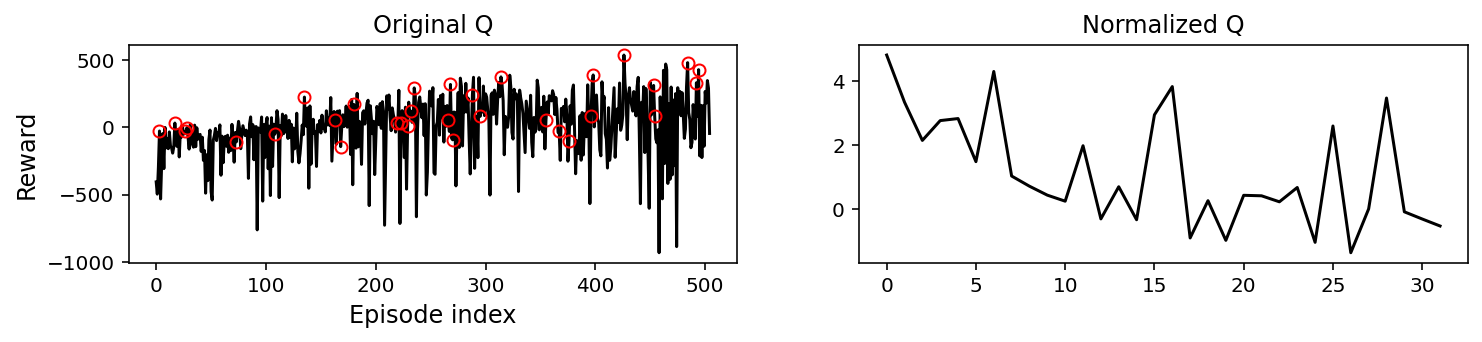

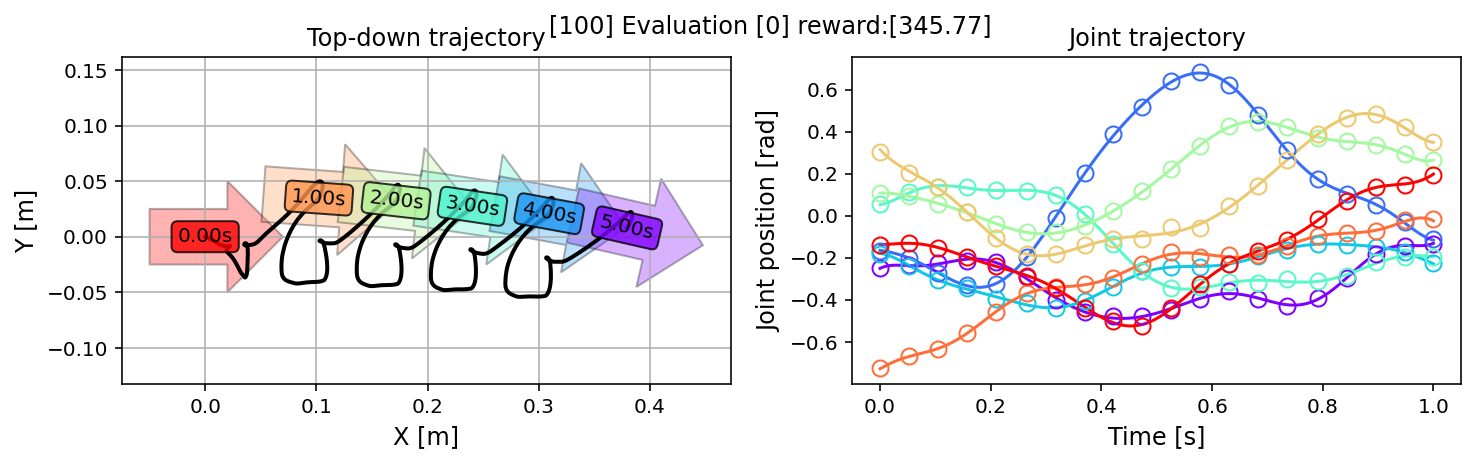

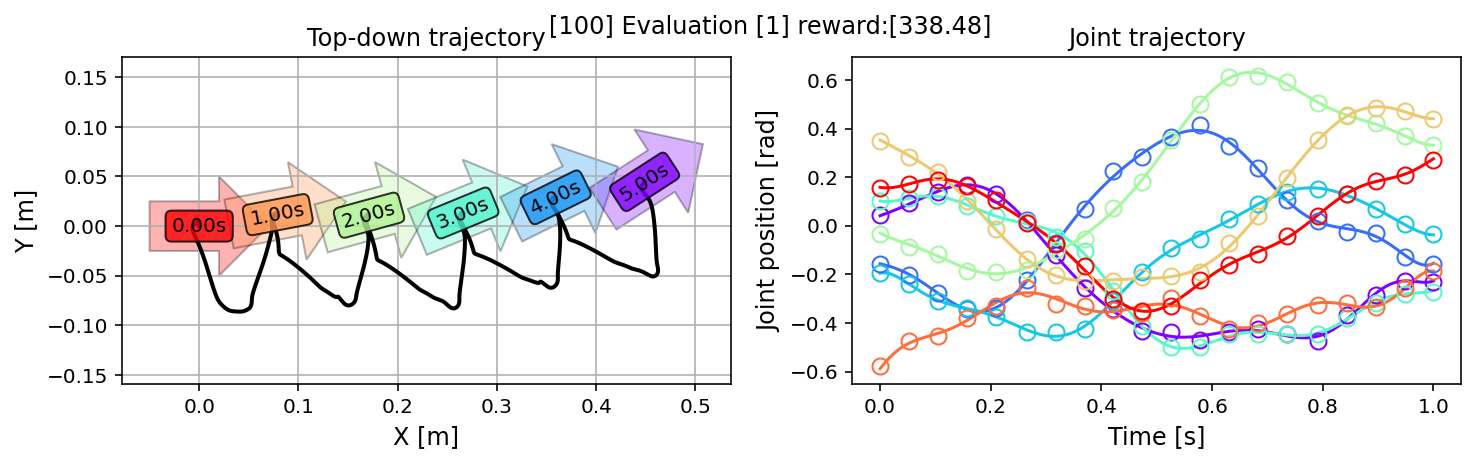

  [100/1000][Eval] reward_avg:[342.12]
[../weight/U-DLPG-SNAPBOT/wb_0100.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0100.pickle] saved.
[110/1000] wall:[135.00]sec. [555] rollouts. Total loss:[1.413] (recon:[1.339] kl:[0.074])
[120/1000] wall:[147.00]sec. [605] rollouts. Total loss:[1.286] (recon:[1.214] kl:[0.072])
[130/1000] wall:[158.88]sec. [655] rollouts. Total loss:[0.980] (recon:[0.911] kl:[0.069])
[140/1000] wall:[170.80]sec. [705] rollouts. Total loss:[1.192] (recon:[1.131] kl:[0.060])
[150/1000] wall:[182.74]sec. [755] rollouts. Total loss:[1.021] (recon:[0.956] kl:[0.065])
[160/1000] wall:[194.86]sec. [805] rollouts. Total loss:[1.152] (recon:[1.088] kl:[0.064])
[170/1000] wall:[207.00]sec. [855] rollouts. Total loss:[1.294] (recon:[1.229] kl:[0.065])
[180/1000] wall:[218.86]sec. [905] rollouts. Total loss:[1.150] (recon:[1.092] kl:[0.058])
[190/1000] wall:[230.89]sec. [955] rollouts. Total loss:[1.030] (recon:[0.963] kl:[0.067])
[200/1000] wall:[242.87]sec. [1005] rollouts.

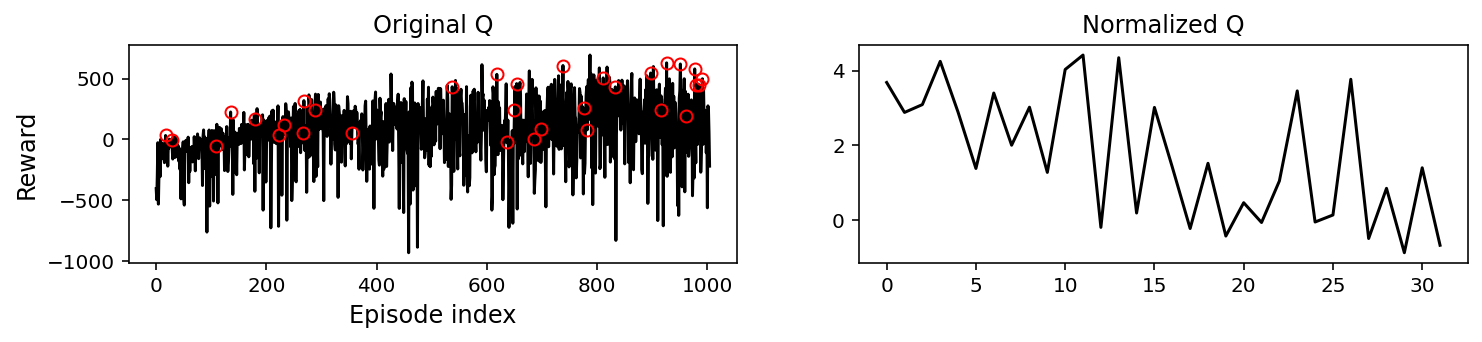

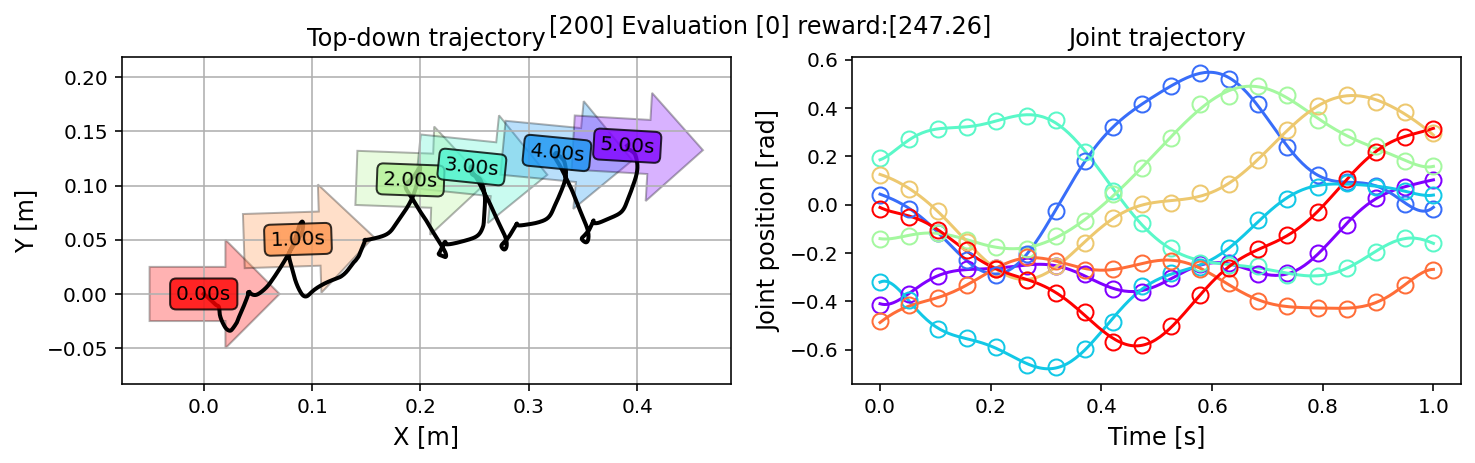

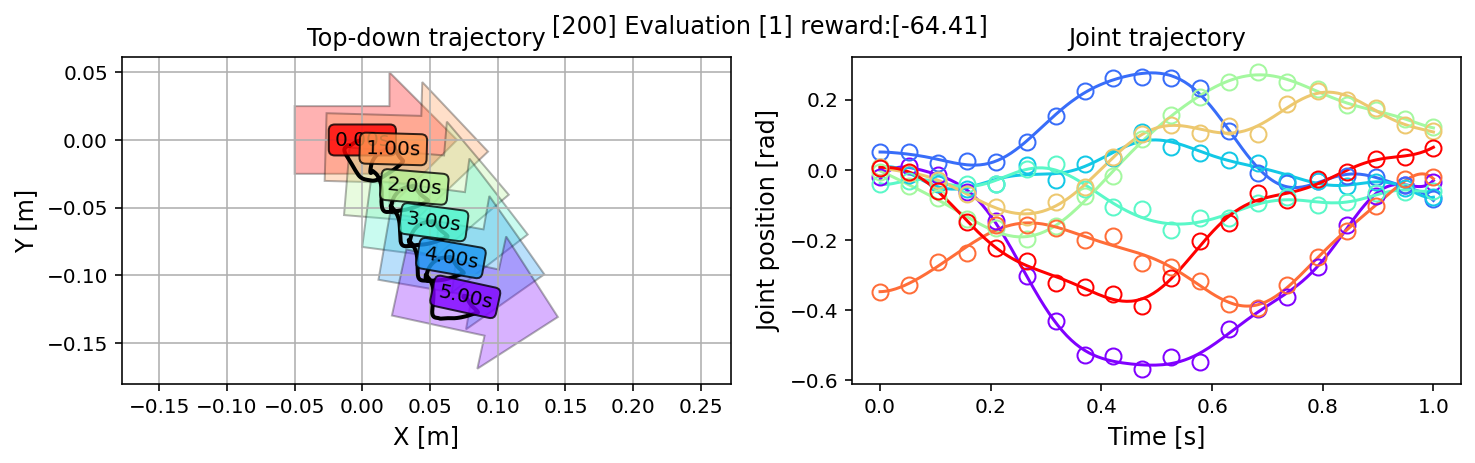

  [200/1000][Eval] reward_avg:[91.43]
[../weight/U-DLPG-SNAPBOT/wb_0200.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0200.pickle] saved.
[210/1000] wall:[255.65]sec. [1055] rollouts. Total loss:[1.229] (recon:[1.172] kl:[0.057])
[220/1000] wall:[267.63]sec. [1105] rollouts. Total loss:[1.195] (recon:[1.135] kl:[0.059])
[230/1000] wall:[279.52]sec. [1155] rollouts. Total loss:[1.021] (recon:[0.961] kl:[0.060])
[240/1000] wall:[291.56]sec. [1205] rollouts. Total loss:[1.069] (recon:[1.012] kl:[0.057])
[250/1000] wall:[303.56]sec. [1255] rollouts. Total loss:[1.255] (recon:[1.197] kl:[0.059])
[260/1000] wall:[315.69]sec. [1305] rollouts. Total loss:[1.121] (recon:[1.061] kl:[0.059])
[270/1000] wall:[327.72]sec. [1355] rollouts. Total loss:[1.303] (recon:[1.248] kl:[0.055])
[280/1000] wall:[340.31]sec. [1405] rollouts. Total loss:[1.024] (recon:[0.967] kl:[0.057])
[290/1000] wall:[352.31]sec. [1455] rollouts. Total loss:[1.179] (recon:[1.123] kl:[0.056])
[300/1000] wall:[364.25]sec. [1505] r

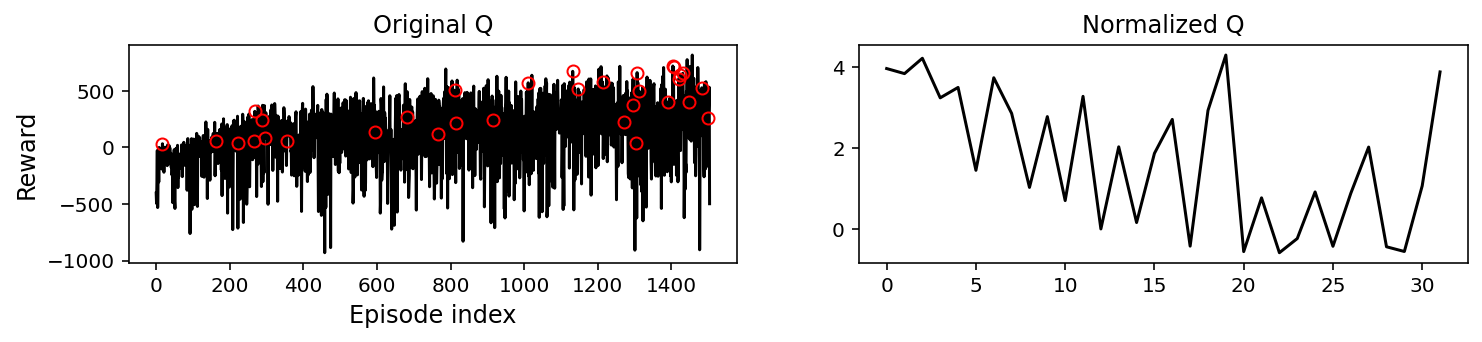

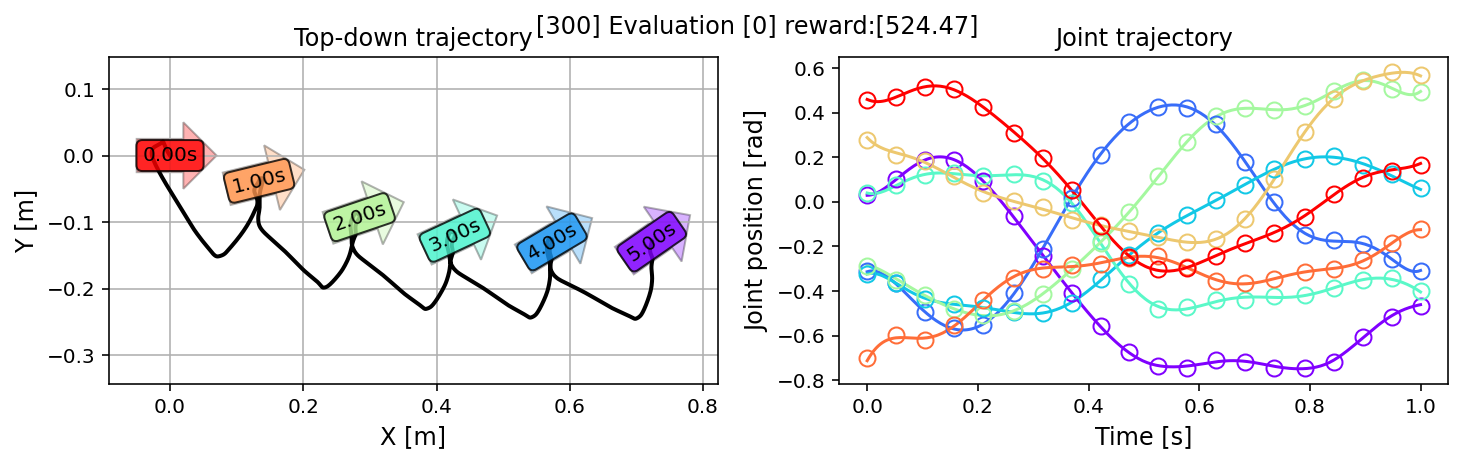

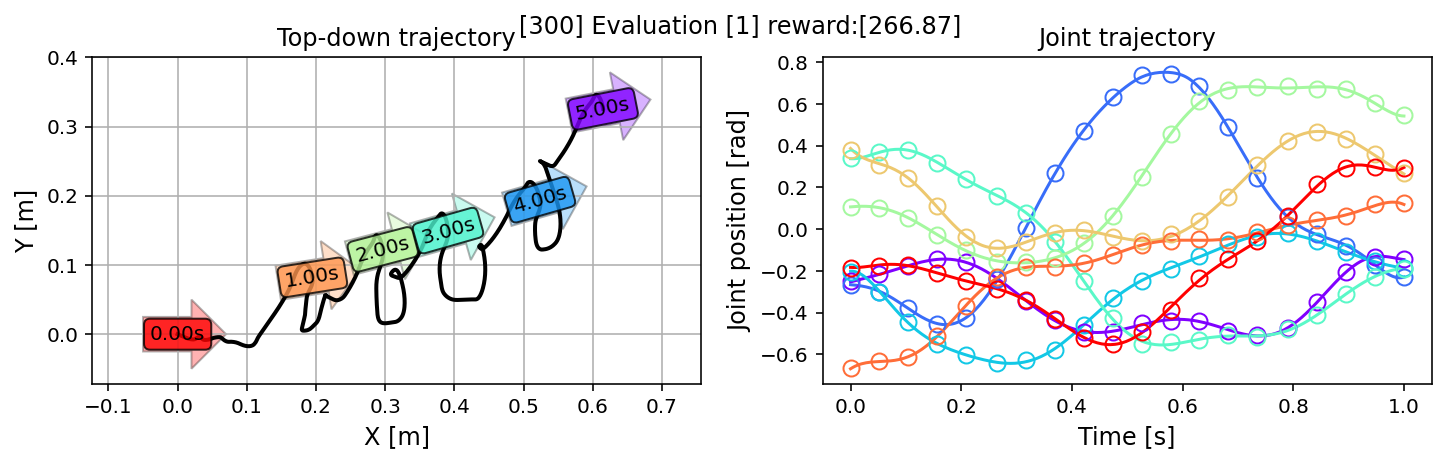

  [300/1000][Eval] reward_avg:[395.67]
[../weight/U-DLPG-SNAPBOT/wb_0300.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0300.pickle] saved.
[310/1000] wall:[377.37]sec. [1555] rollouts. Total loss:[1.015] (recon:[0.963] kl:[0.052])
[320/1000] wall:[389.40]sec. [1605] rollouts. Total loss:[1.485] (recon:[1.426] kl:[0.059])
[330/1000] wall:[401.55]sec. [1655] rollouts. Total loss:[1.191] (recon:[1.134] kl:[0.056])
[340/1000] wall:[413.65]sec. [1705] rollouts. Total loss:[1.251] (recon:[1.195] kl:[0.057])
[350/1000] wall:[425.73]sec. [1755] rollouts. Total loss:[1.076] (recon:[1.020] kl:[0.056])
[360/1000] wall:[437.84]sec. [1805] rollouts. Total loss:[1.044] (recon:[0.990] kl:[0.054])
[370/1000] wall:[449.89]sec. [1855] rollouts. Total loss:[1.187] (recon:[1.131] kl:[0.056])
[380/1000] wall:[461.99]sec. [1905] rollouts. Total loss:[1.076] (recon:[1.024] kl:[0.053])
[390/1000] wall:[474.23]sec. [1955] rollouts. Total loss:[1.284] (recon:[1.232] kl:[0.052])
[400/1000] wall:[486.27]sec. [2005] 

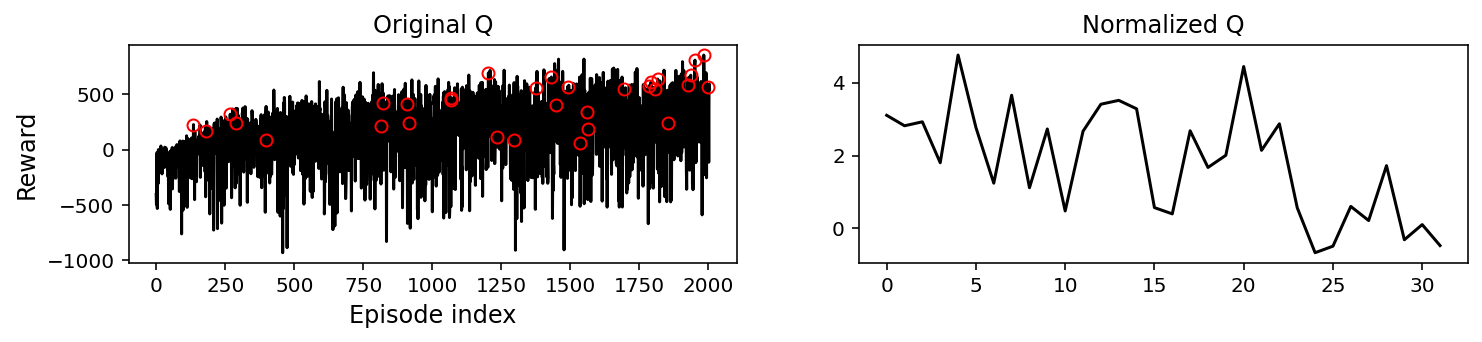

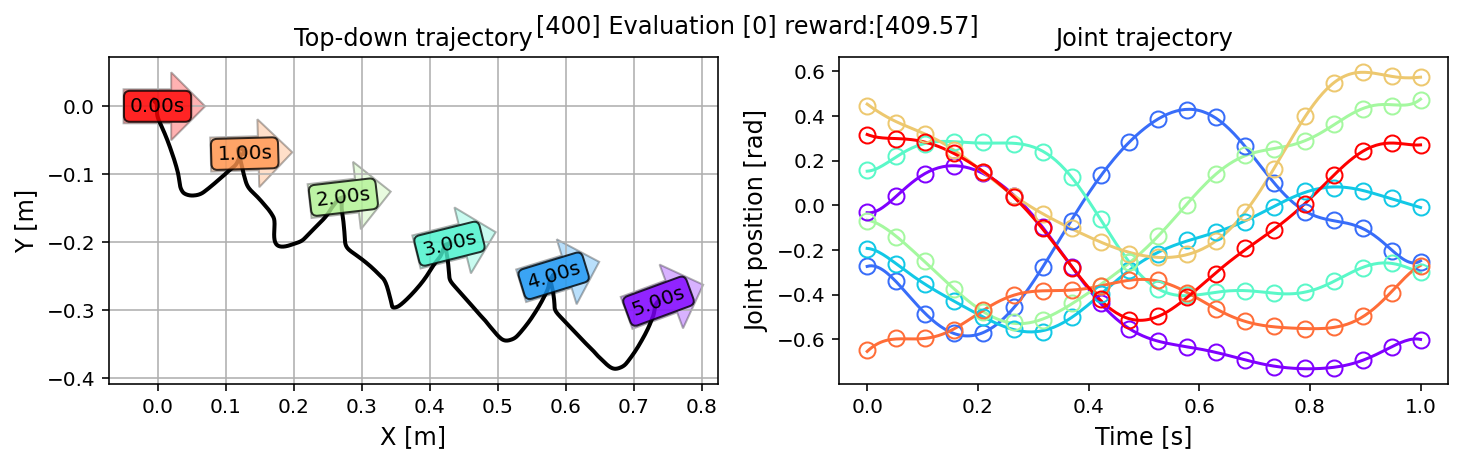

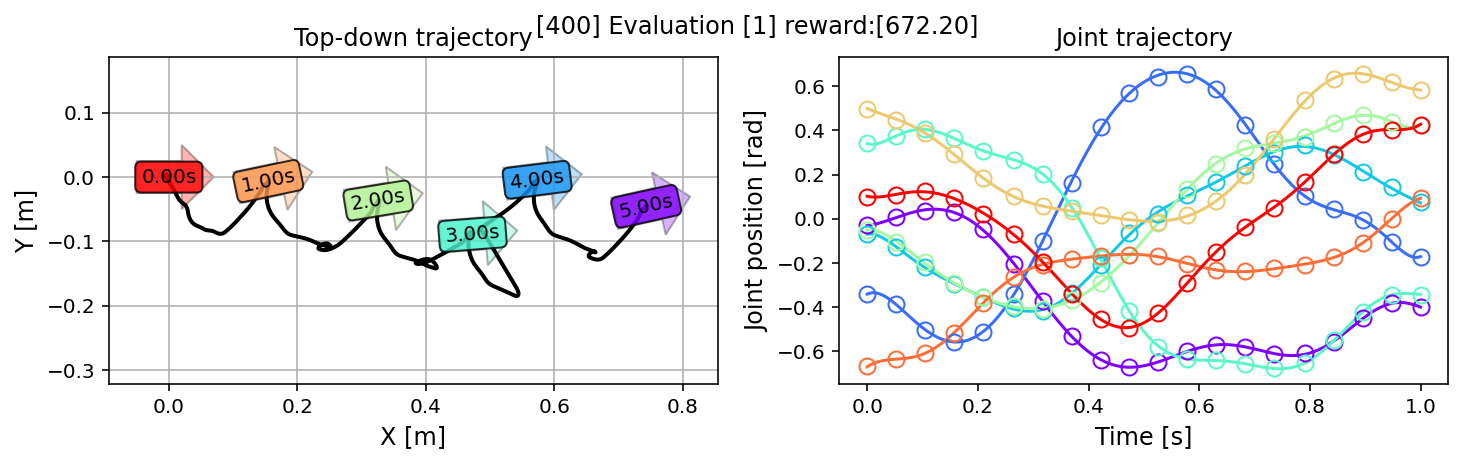

  [400/1000][Eval] reward_avg:[540.88]
[../weight/U-DLPG-SNAPBOT/wb_0400.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0400.pickle] saved.
[410/1000] wall:[499.26]sec. [2055] rollouts. Total loss:[1.240] (recon:[1.188] kl:[0.052])
[420/1000] wall:[511.25]sec. [2105] rollouts. Total loss:[1.387] (recon:[1.333] kl:[0.055])
[430/1000] wall:[523.24]sec. [2155] rollouts. Total loss:[1.250] (recon:[1.193] kl:[0.057])
[440/1000] wall:[535.35]sec. [2205] rollouts. Total loss:[1.076] (recon:[1.020] kl:[0.057])
[450/1000] wall:[547.35]sec. [2255] rollouts. Total loss:[1.318] (recon:[1.265] kl:[0.053])
[460/1000] wall:[559.43]sec. [2305] rollouts. Total loss:[1.137] (recon:[1.084] kl:[0.053])
[470/1000] wall:[571.46]sec. [2355] rollouts. Total loss:[1.375] (recon:[1.323] kl:[0.052])
[480/1000] wall:[583.47]sec. [2405] rollouts. Total loss:[1.255] (recon:[1.201] kl:[0.054])
[490/1000] wall:[595.59]sec. [2455] rollouts. Total loss:[1.316] (recon:[1.261] kl:[0.055])
[500/1000] wall:[607.61]sec. [2505] 

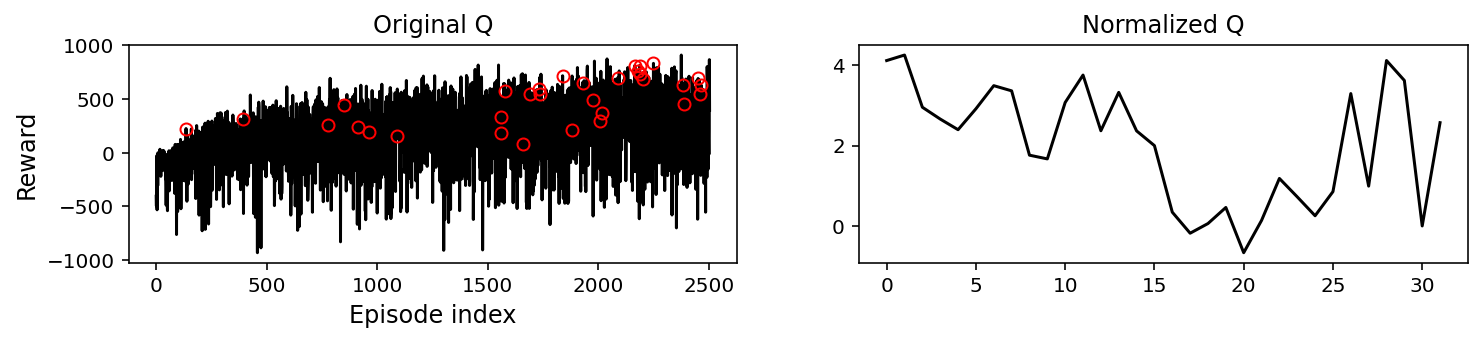

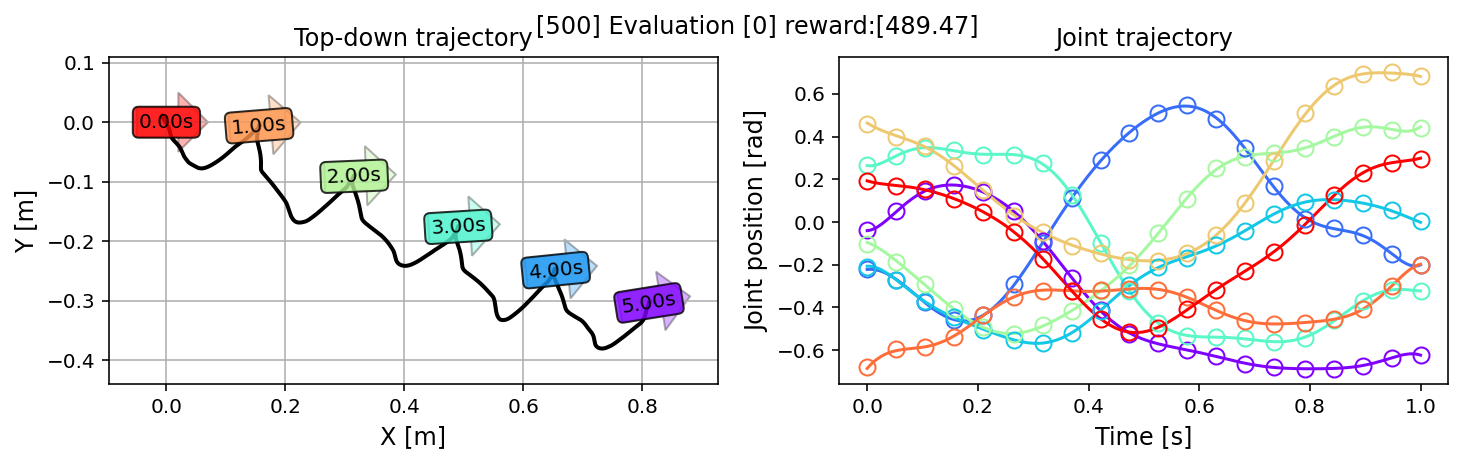

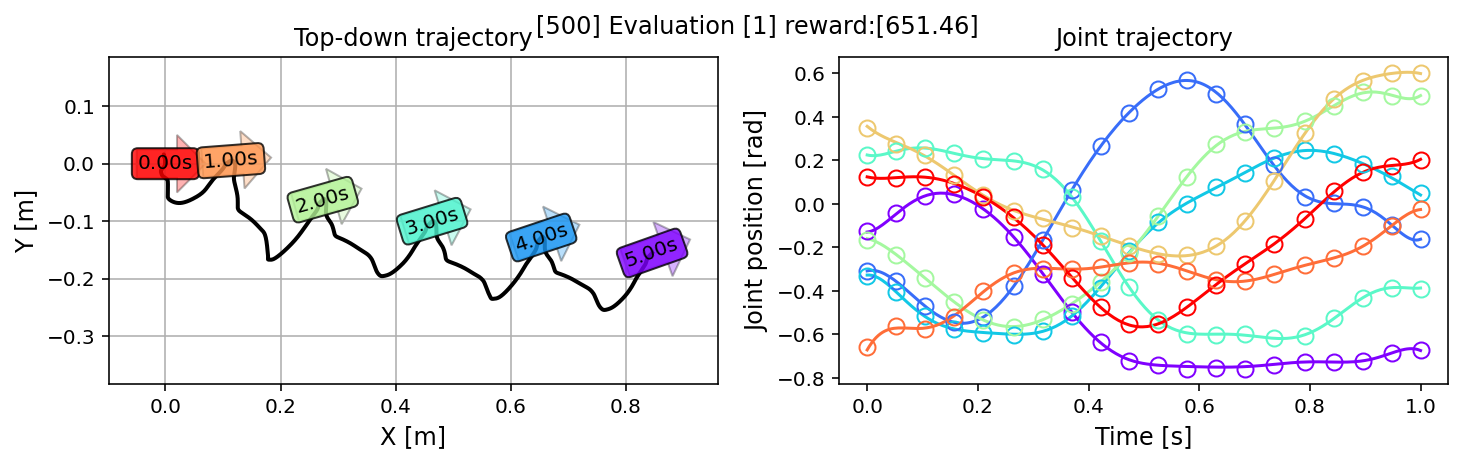

  [500/1000][Eval] reward_avg:[570.47]
[../weight/U-DLPG-SNAPBOT/wb_0500.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0500.pickle] saved.
[510/1000] wall:[620.69]sec. [2555] rollouts. Total loss:[1.280] (recon:[1.228] kl:[0.052])
[520/1000] wall:[632.71]sec. [2605] rollouts. Total loss:[1.411] (recon:[1.359] kl:[0.051])
[530/1000] wall:[644.70]sec. [2655] rollouts. Total loss:[1.261] (recon:[1.209] kl:[0.051])
[540/1000] wall:[656.77]sec. [2705] rollouts. Total loss:[1.452] (recon:[1.397] kl:[0.054])
[550/1000] wall:[668.97]sec. [2755] rollouts. Total loss:[1.181] (recon:[1.130] kl:[0.051])
[560/1000] wall:[681.39]sec. [2805] rollouts. Total loss:[1.521] (recon:[1.470] kl:[0.051])
[570/1000] wall:[693.53]sec. [2855] rollouts. Total loss:[1.348] (recon:[1.294] kl:[0.054])
[580/1000] wall:[705.61]sec. [2905] rollouts. Total loss:[1.553] (recon:[1.497] kl:[0.056])
[590/1000] wall:[717.70]sec. [2955] rollouts. Total loss:[1.353] (recon:[1.298] kl:[0.055])
[600/1000] wall:[729.77]sec. [3005] 

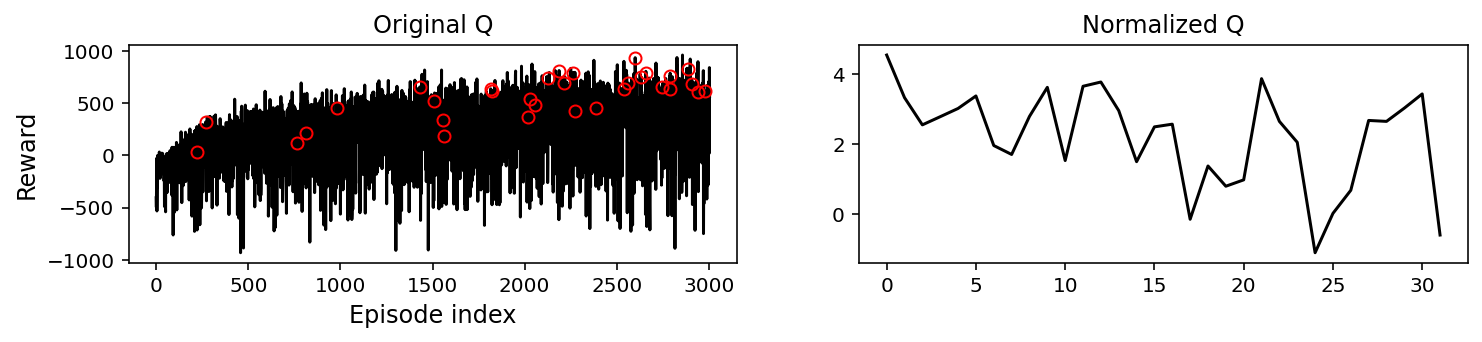

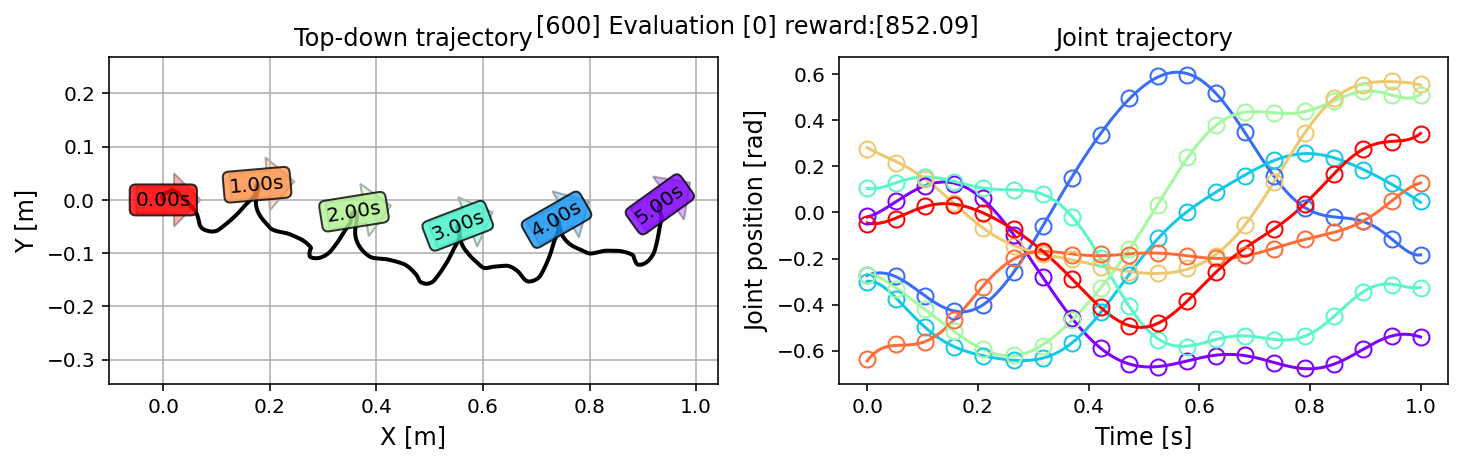

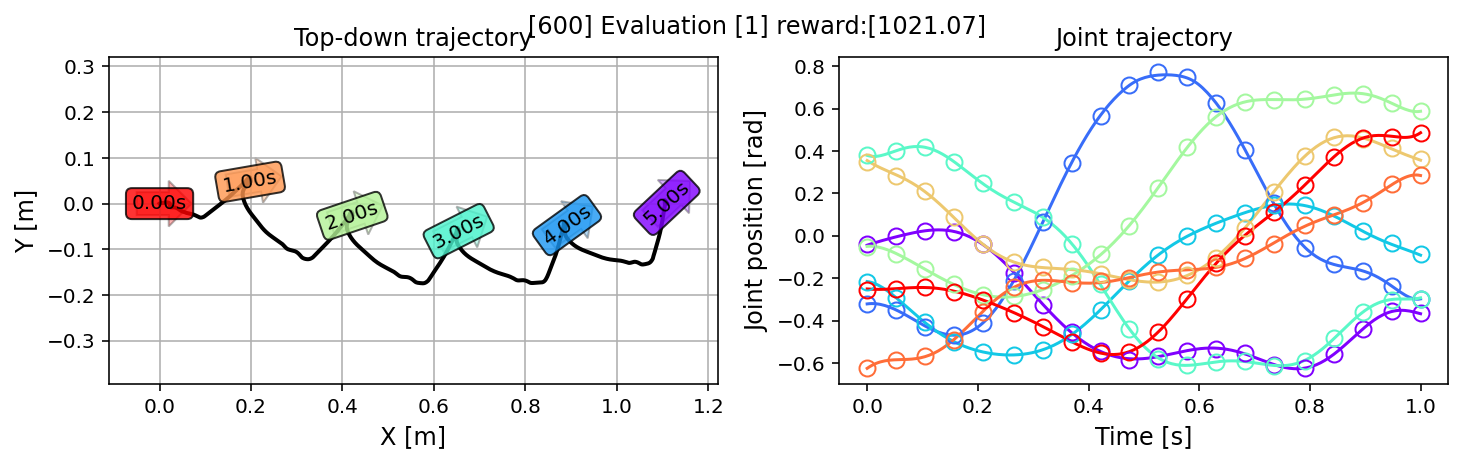

  [600/1000][Eval] reward_avg:[936.58]
[../weight/U-DLPG-SNAPBOT/wb_0600.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0600.pickle] saved.
[610/1000] wall:[742.77]sec. [3055] rollouts. Total loss:[1.350] (recon:[1.298] kl:[0.051])
[620/1000] wall:[754.99]sec. [3105] rollouts. Total loss:[1.313] (recon:[1.262] kl:[0.051])
[630/1000] wall:[767.10]sec. [3155] rollouts. Total loss:[1.433] (recon:[1.381] kl:[0.052])
[640/1000] wall:[779.33]sec. [3205] rollouts. Total loss:[1.397] (recon:[1.345] kl:[0.052])
[650/1000] wall:[791.52]sec. [3255] rollouts. Total loss:[1.273] (recon:[1.220] kl:[0.053])
[660/1000] wall:[803.65]sec. [3305] rollouts. Total loss:[1.226] (recon:[1.172] kl:[0.054])
[670/1000] wall:[815.81]sec. [3355] rollouts. Total loss:[1.187] (recon:[1.129] kl:[0.057])
[680/1000] wall:[828.04]sec. [3405] rollouts. Total loss:[1.307] (recon:[1.255] kl:[0.053])
[690/1000] wall:[840.23]sec. [3455] rollouts. Total loss:[1.333] (recon:[1.281] kl:[0.053])
[700/1000] wall:[852.37]sec. [3505] 

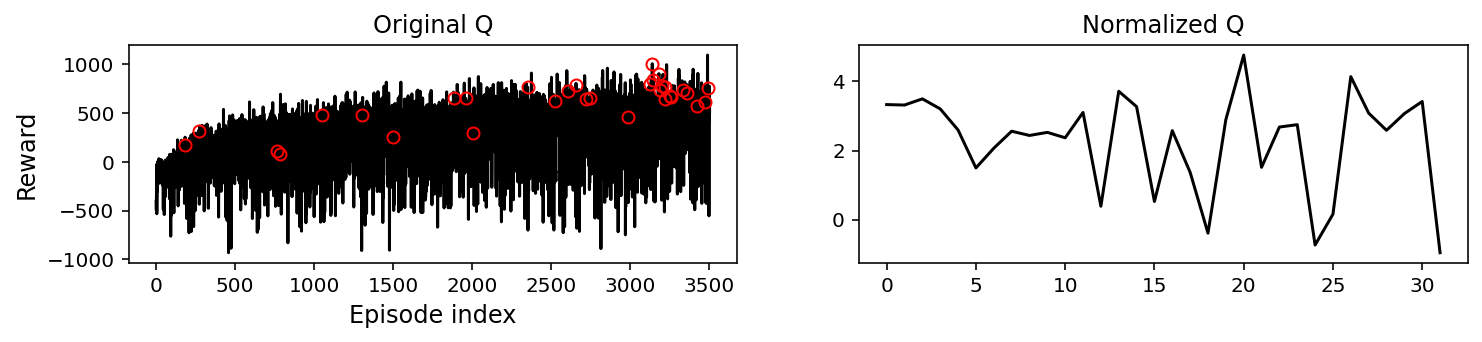

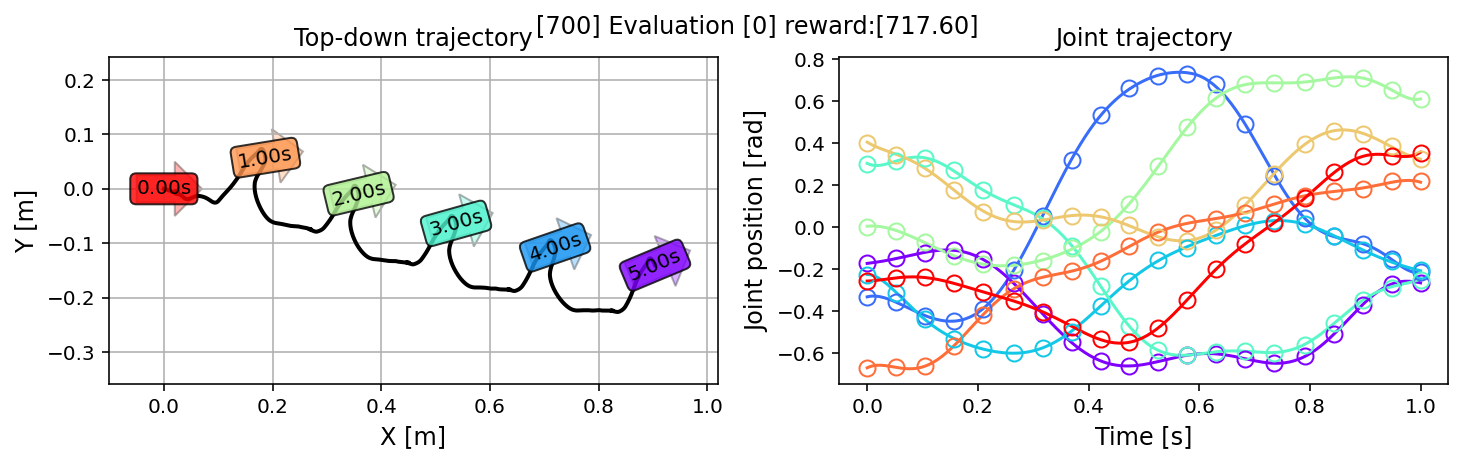

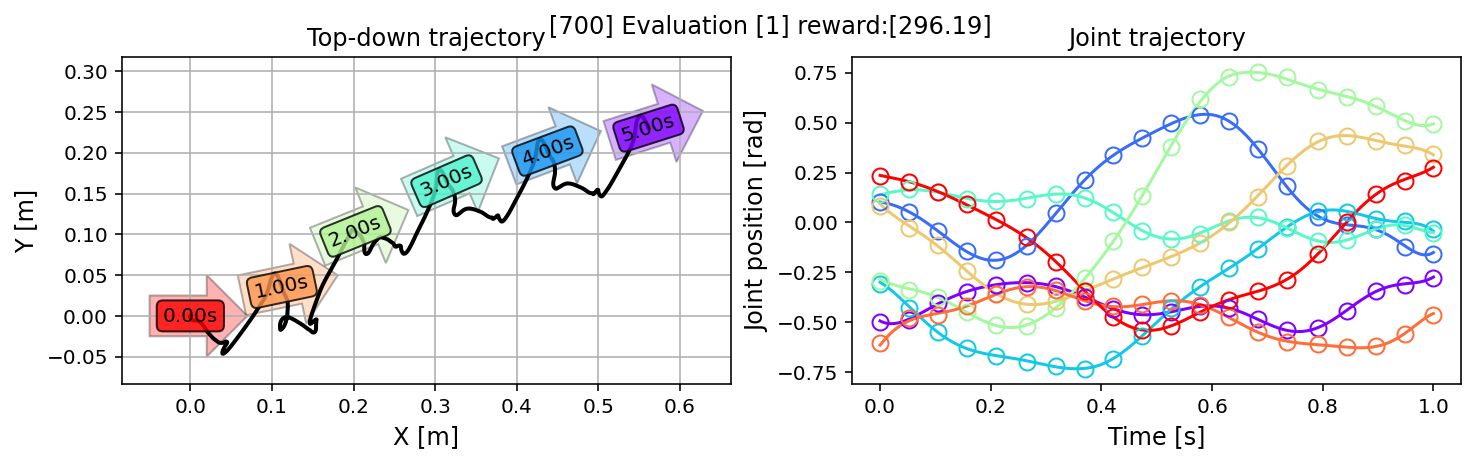

  [700/1000][Eval] reward_avg:[506.89]
[../weight/U-DLPG-SNAPBOT/wb_0700.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0700.pickle] saved.
[710/1000] wall:[865.32]sec. [3555] rollouts. Total loss:[1.206] (recon:[1.155] kl:[0.052])
[720/1000] wall:[877.53]sec. [3605] rollouts. Total loss:[1.311] (recon:[1.259] kl:[0.052])
[730/1000] wall:[889.72]sec. [3655] rollouts. Total loss:[1.309] (recon:[1.259] kl:[0.051])
[740/1000] wall:[901.85]sec. [3705] rollouts. Total loss:[1.372] (recon:[1.318] kl:[0.054])
[750/1000] wall:[913.97]sec. [3755] rollouts. Total loss:[1.276] (recon:[1.224] kl:[0.052])
[760/1000] wall:[926.13]sec. [3805] rollouts. Total loss:[1.281] (recon:[1.228] kl:[0.053])
[770/1000] wall:[938.26]sec. [3855] rollouts. Total loss:[1.341] (recon:[1.290] kl:[0.051])
[780/1000] wall:[950.42]sec. [3905] rollouts. Total loss:[1.281] (recon:[1.227] kl:[0.053])
[790/1000] wall:[962.61]sec. [3955] rollouts. Total loss:[1.142] (recon:[1.090] kl:[0.052])
[800/1000] wall:[974.94]sec. [4005] 

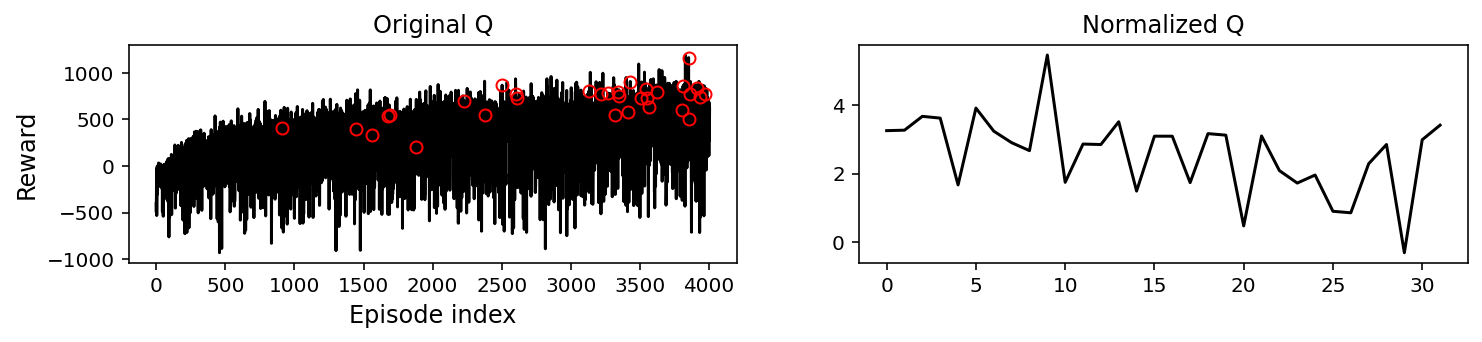

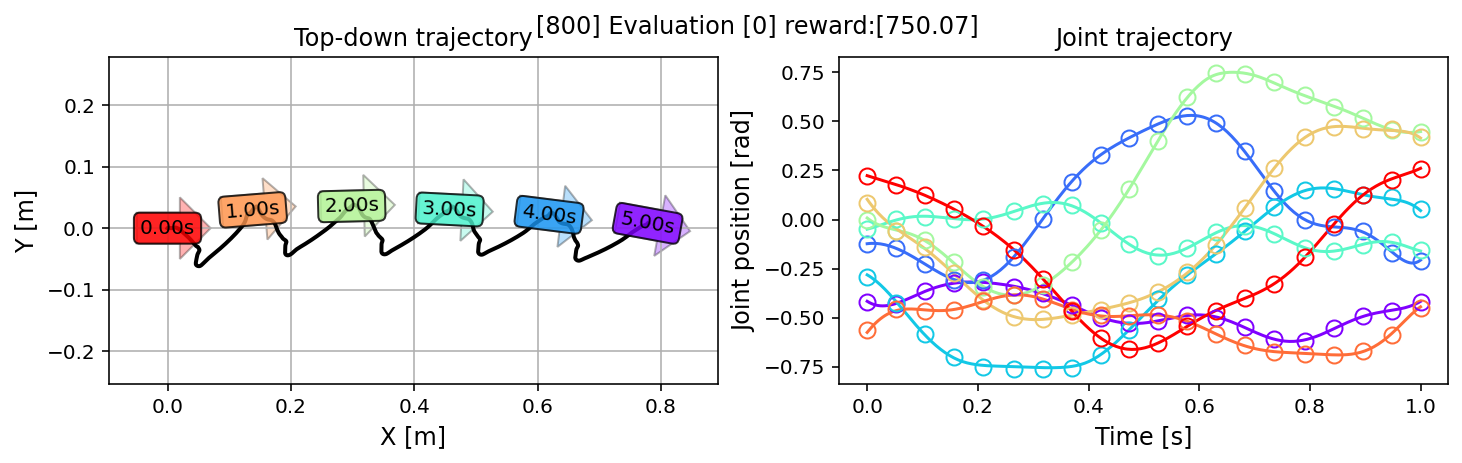

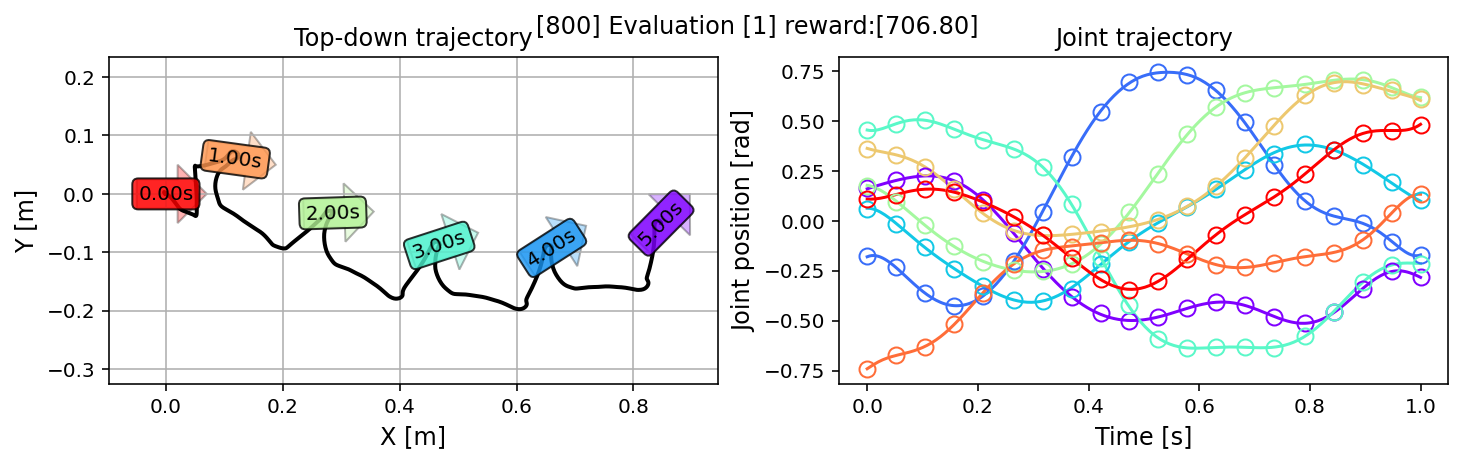

  [800/1000][Eval] reward_avg:[728.43]
[../weight/U-DLPG-SNAPBOT/wb_0800.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0800.pickle] saved.
[810/1000] wall:[988.06]sec. [4055] rollouts. Total loss:[1.110] (recon:[1.059] kl:[0.051])
[820/1000] wall:[1000.28]sec. [4105] rollouts. Total loss:[1.253] (recon:[1.202] kl:[0.051])
[830/1000] wall:[1201.43]sec. [4155] rollouts. Total loss:[1.413] (recon:[1.359] kl:[0.054])
[840/1000] wall:[1215.48]sec. [4205] rollouts. Total loss:[1.130] (recon:[1.078] kl:[0.052])
[850/1000] wall:[1228.19]sec. [4255] rollouts. Total loss:[1.116] (recon:[1.064] kl:[0.053])
[860/1000] wall:[1240.70]sec. [4305] rollouts. Total loss:[1.139] (recon:[1.087] kl:[0.052])
[870/1000] wall:[1253.42]sec. [4355] rollouts. Total loss:[1.145] (recon:[1.095] kl:[0.050])
[880/1000] wall:[1266.39]sec. [4405] rollouts. Total loss:[1.425] (recon:[1.374] kl:[0.050])
[890/1000] wall:[1278.62]sec. [4455] rollouts. Total loss:[1.253] (recon:[1.201] kl:[0.053])
[900/1000] wall:[1290.86]sec

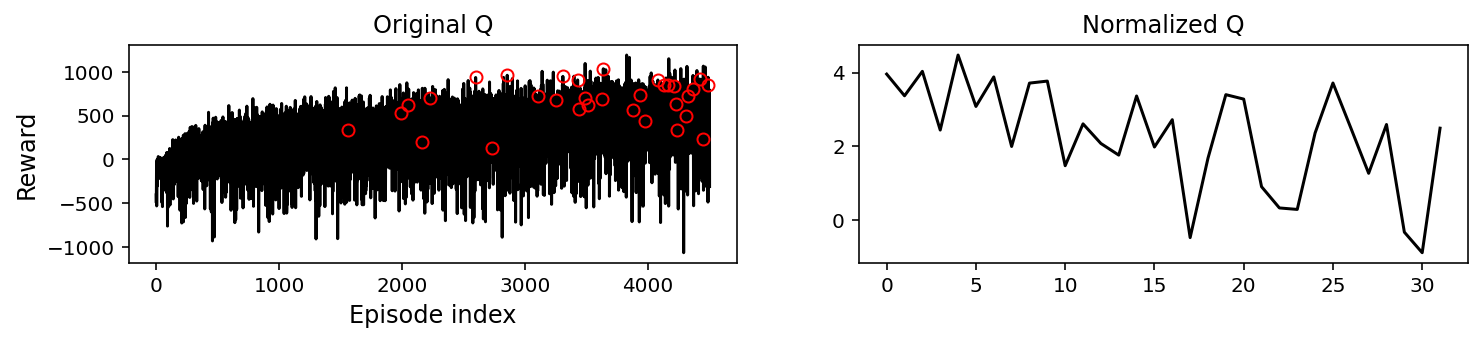

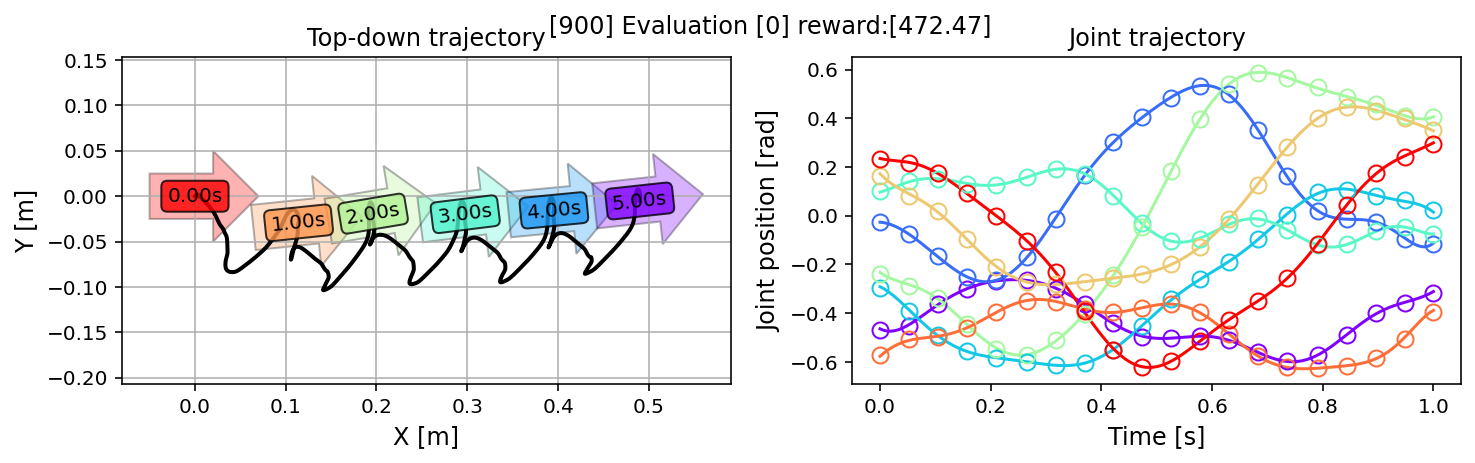

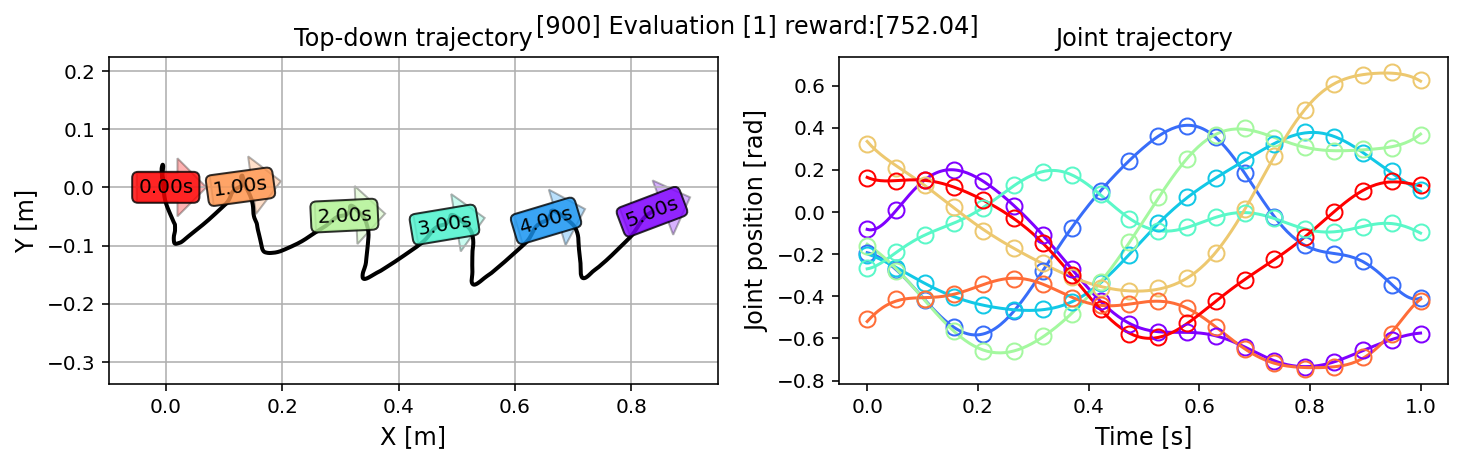

  [900/1000][Eval] reward_avg:[612.26]
[../weight/U-DLPG-SNAPBOT/wb_0900.pth] saved.
[../weight/U-DLPG-SNAPBOT/xnzr_0900.pickle] saved.
[910/1000] wall:[1303.85]sec. [4555] rollouts. Total loss:[1.181] (recon:[1.130] kl:[0.051])
[920/1000] wall:[1316.05]sec. [4605] rollouts. Total loss:[1.214] (recon:[1.162] kl:[0.052])
[930/1000] wall:[1328.40]sec. [4655] rollouts. Total loss:[1.503] (recon:[1.452] kl:[0.051])
[940/1000] wall:[1340.76]sec. [4705] rollouts. Total loss:[0.943] (recon:[0.892] kl:[0.051])
[950/1000] wall:[1353.22]sec. [4755] rollouts. Total loss:[1.156] (recon:[1.104] kl:[0.052])
[960/1000] wall:[1365.63]sec. [4805] rollouts. Total loss:[1.338] (recon:[1.286] kl:[0.052])
[970/1000] wall:[1378.07]sec. [4855] rollouts. Total loss:[1.354] (recon:[1.302] kl:[0.053])
[980/1000] wall:[1390.54]sec. [4905] rollouts. Total loss:[1.288] (recon:[1.239] kl:[0.050])
[990/1000] wall:[1403.09]sec. [4955] rollouts. Total loss:[1.500] (recon:[1.446] kl:[0.054])
Done.


In [5]:
DLPG.init_params(seed=0)
tic = TicTocClass()
buffer = []
for update_idx in range(n_update):
    zero_to_one,one_to_zero = (update_idx/max(1,n_update-1)),1.0-(update_idx/max(1,n_update-1))
    for rollout_idx in range(n_rollout_per_update):
        exploration_rate = 0.25*one_to_zero
        if (np.random.rand()<=exploration_rate) or (update_idx==0): # exploration
            traj_joints,traj_secs = GRP_prior.sample_one_traj(
                rand_type='Gaussian',ss_x_min=ss_range[:,0],ss_x_max=ss_range[:,1],ss_margin=ss_margin)
        else:
            x_recon_np  = torch2np(DLPG.sample_x(c=None,n_sample=1,SKIP_Z_SAMPLE=True))
            x_anchor    = X_NZR.get_org_data(x_recon_np).reshape((n_anchor,env.n_actuator))
            traj_joints = GRP_posterior.lev_interpolate(
                t_anchor=t_anchor,x_anchor=x_anchor,t_test=traj_secs,hyp={'g':1,'l':1/4,'w':1e-8},lev_val=0.97,
                x_min=ss_range[:,0],x_max=ss_range[:,1],margin=ss_margin)
        # Rollout
        res = snapbot_rollout(env,PID,traj_joints,n_traj_repeat=n_traj_repeat,DO_RENDER=False)
        reward = get_snapbot_reward(res['xyrad_list'],
                                    fwd_gain=fwd_gain,side_penalty=side_penalty,rot_penalty=rot_penalty)
        t_anchor,x_anchor = get_anchors_from_traj(traj_secs,traj_joints,n_anchor=n_anchor) # [20 x 1], [20 x 8]
        buffer.append({'t_anchor':t_anchor,'x_anchor':x_anchor,'reward':reward})
    # Accumulate buffer
    x_data,q_data = np.zeros(shape=(len(buffer),env.n_actuator*n_anchor)),np.zeros(shape=(len(buffer)))
    for idx in range(len(buffer)):
        x_data[idx,:],q_data[idx] = buffer[idx]['x_anchor'].reshape((1,-1)),buffer[idx]['reward']
    # Normalize
    if (len(x_data)<=500): 
        X_NZR = NormalizerClass(name='X',x=x_data)
    x_data_nzd = X_NZR.get_nzd_data(x_data)
    q_data_nzd = 2*whitening(q_data)
    # Select subset
    if len(x_data) > n_dpp_subset:
        _,idxs_ikdpp = ikdpp(xs_total=x_data_nzd,qs_total=0.1*q_data_nzd,n_select=n_dpp_subset,
                             n_trunc=100,hyp={'g':1.0,'l':10.0})
        x_data_nzd_trim,q_data_nzd_trim = x_data_nzd[idxs_ikdpp,:],q_data_nzd[idxs_ikdpp]
    else:
        x_data_nzd_trim,q_data_nzd_trim = x_data_nzd,q_data_nzd
    # Update DLPG
    x_data_nzd_torch,q_data_nzd_torch = np2torch(x_data_nzd_trim),np2torch(q_data_nzd_trim)
    loss_recon_sum,loss_kl_sum,n_batch_sum = 0.0,0.0,0
    for it in range(n_iter_per_update):
        if it >= (n_iter_per_update//2): beta = 0.01 
        else: beta = 0.0
        batch_idx = np.random.permutation(len(x_data_nzd_torch))[:batch_size]
        x_batch_torch,q_batch_torch = x_data_nzd_torch[batch_idx,:],q_data_nzd_torch[batch_idx]
        if Q_RENORMALIZE: q_batch_torch = 2*whitening_torch(q_batch_torch) # (optional)
        n_batch = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = DLPG.loss_total(
            x=x_batch_torch,c=None,q=q_batch_torch,LOSS_TYPE='L1+L2',
            recon_loss_gain=10.0,beta=beta,STOCHASTICITY=True)
        optm.zero_grad(); total_loss_out.backward(); optm.step() # update
        loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_kl_sum    = loss_kl_sum + n_batch*loss_info['loss_kl_out']
        n_batch_sum    = n_batch_sum + n_batch
    loss_recon_avg,loss_kl_avg = (loss_recon_sum/n_batch_sum),(loss_kl_sum/n_batch_sum)
    # Print
    if (update_idx%print_every_update)==0:
        print ("[%d/%d] wall:[%.2f]sec. [%d] rollouts. Total loss:[%.3f] (recon:[%.3f] kl:[%.3f])"%
               (update_idx,n_update,tic.toc(),len(buffer),
                loss_recon_avg+loss_kl_avg,loss_recon_avg,loss_kl_avg))
    # Evaluate
    if (update_idx%evaluate_every_update)==0:
        # Plot reward history
        plt.figure(figsize=(12,2))
        plt.subplot(1,2,1); ticks = np.arange(0,len(q_data),1); plt.plot(ticks,q_data,'-',color='k');
        plt.xlabel('Episode index',fontsize=12); plt.ylabel('Reward',fontsize=12)
        if len(x_data) > n_dpp_subset: plt.plot(ticks[idxs_ikdpp],q_data[idxs_ikdpp],'o',color='r',mfc='none');
        plt.title('Original Q',fontsize=12); plt.ylabel('Reward',fontsize=12)
        plt.subplot(1,2,2); plt.plot(q_data_nzd_trim,'-',color='k'); plt.title('Normalized Q',fontsize=12); 
        plt.show()
        # Evaluate
        reward_sum = 0.0
        for e_idx in range(n_rollout_per_eval):
            # Rollout
            x_recon_np  = torch2np(DLPG.sample_x(c=None,n_sample=1,SKIP_Z_SAMPLE=True)) # [1 x 160]
            x_anchor    = X_NZR.get_org_data(x_recon_np).reshape((n_anchor,env.n_actuator))
            traj_joints = GRP_posterior.lev_interpolate(
                t_anchor=t_anchor,x_anchor=x_anchor,t_test=traj_secs,hyp={'g':1,'l':1/4,'w':1e-8},lev_val=1.0,
                APPLY_EPSRU=True,t_eps=0.01,
                x_min=ss_range[:,0],x_max=ss_range[:,1],margin=ss_margin)
            res_eval = snapbot_rollout(
                env,PID,traj_joints,n_traj_repeat=n_traj_repeat,DO_RENDER=DO_RENDER_WHILE_EVAL)
            reward   = get_snapbot_reward(
                res_eval['xyrad_list'],fwd_gain=fwd_gain,side_penalty=side_penalty,rot_penalty=rot_penalty)
            reward_sum = reward_sum + reward
            # Plot top-down torso and joint trajectories
            plot_topdown_trajectory_and_joint_trajectory(
                res_eval['sec_list'],res_eval['xyrad_list'],
                n_arrow = n_traj_repeat+1,cm=plt.cm.rainbow_r,
                traj_secs=traj_secs,traj_joints=traj_joints,
                t_anchor=t_anchor,x_anchor=x_anchor,
                figsize=(12,3),title_str='[%d] Evaluation [%d] reward:[%.2f]'%(update_idx,e_idx,reward))
        reward_avg = reward_sum/n_rollout_per_eval
        print ("  [%d/%d][Eval] reward_avg:[%.2f]"%(update_idx,n_update,reward_avg))
    
    # Save weights
    if (update_idx%save_every_update)==0:
        folder_path = '../weight/%s/'%(DLPG.name)
        pth_name    = 'wb_%04d.pth'%(update_idx)
        pickle_path = '../weight/%s/xnzr_%04d.pickle'%(DLPG.name,update_idx)
        save_torch_wb(DLPG,folder_path=folder_path,pth_name=pth_name,VERBOSE=True)
        X_NZR.save(pickle_path=pickle_path)
    
print ("Done.")

In [10]:
# Rollout 
update_idx    = 900
n_traj_repeat = 10
DLPG.init_params()
folder_path = '../weight/%s/'%(DLPG.name)
pth_name    = 'wb_%04d.pth'%(update_idx)
pickle_path = '../weight/%s/xnzr_%04d.pickle'%(DLPG.name,update_idx)
load_torch_wb(DLPG,folder_path=folder_path,pth_name=pth_name,VERBOSE=True)
X_NZR = NormalizerClass(name='X',x=np.random.rand(100,4))
X_NZR.restore(pickle_path)

traj_joints = GRP_posterior.lev_interpolate(
                t_anchor=t_anchor,x_anchor=x_anchor,t_test=traj_secs,hyp={'g':1,'l':1/4,'w':1e-8},lev_val=1.0,
                APPLY_EPSRU=True,t_eps=0.01,
                x_min=ss_range[:,0],x_max=ss_range[:,1],margin=ss_margin)
t_anchor,x_anchor = get_anchors_from_traj(traj_secs,traj_joints,n_anchor=n_anchor) # [20 x 1], [20 x 8]

x_recon_np  = torch2np(DLPG.sample_x(c=None,n_sample=1,SKIP_Z_SAMPLE=True)) # [1 x 160]
x_anchor    = X_NZR.get_org_data(x_recon_np).reshape((n_anchor,env.n_actuator))
t_anchor    = np.linspace(0,dur_sec,n_anchor).reshape((-1,1))
traj_joints = GRP_posterior.lev_interpolate(
                t_anchor=t_anchor,x_anchor=x_anchor,t_test=traj_secs,hyp={'g':1,'l':1/4,'w':1e-8},lev_val=1.0,
                APPLY_EPSRU=True,t_eps=0.01,
                x_min=ss_range[:,0],x_max=ss_range[:,1],margin=ss_margin)
res_eval = snapbot_rollout(env,PID,traj_joints,n_traj_repeat=n_traj_repeat,DO_RENDER=True)
env.terminate_viewer()

[../weight/U-DLPG-SNAPBOT/wb_0900.pth] loaded.
[../weight/U-DLPG-SNAPBOT/xnzr_0900.pickle] restored.
Creating window glfw
Creating window glfw


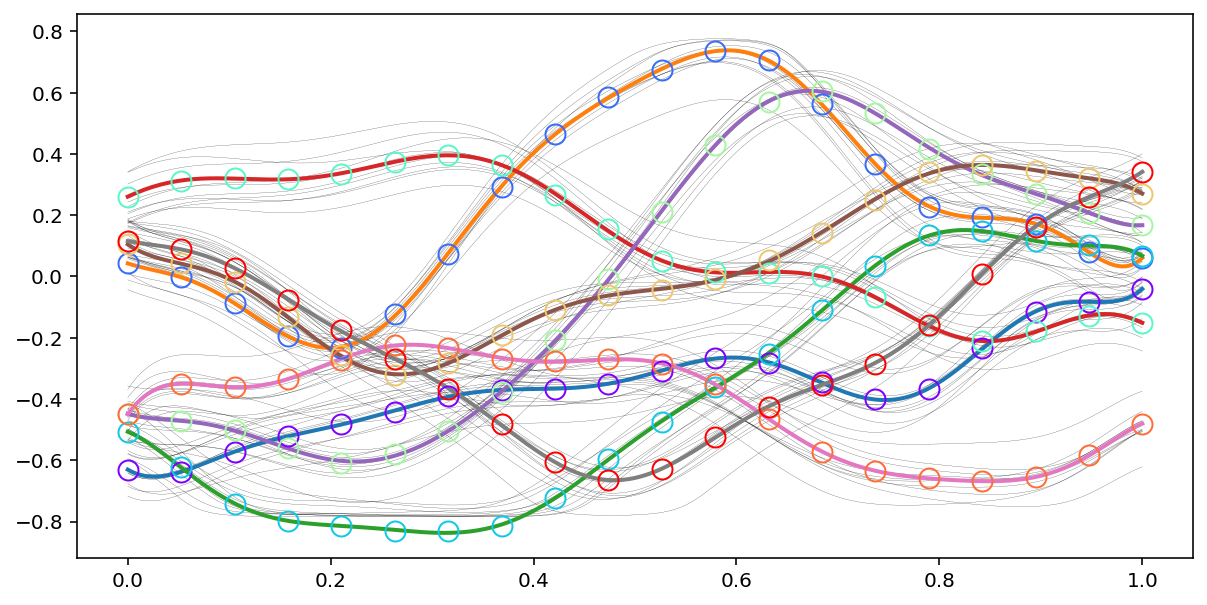

In [7]:
# Check how the leveraged interolation works 
x_recon_np  = torch2np(DLPG.sample_x(c=None,n_sample=1,SKIP_Z_SAMPLE=True))
x_anchor    = X_NZR.get_org_data(x_recon_np).reshape((n_anchor,env.n_actuator))
traj_joints_list = []
for _ in range(10):
    traj_joints = GRP_posterior.lev_interpolate(
        t_anchor=t_anchor,x_anchor=x_anchor,t_test=traj_secs,hyp={'g':1,'l':1/4,'w':1e-8},lev_val=0.97,
        x_min=ss_range[:,0],x_max=ss_range[:,1],margin=ss_margin)
    traj_joints_list.append(traj_joints)
mean_traj   = GRP_posterior.mean_test
# Plot
plt.figure(figsize=(10,5))
for i_idx in range(10):
    traj_joints = traj_joints_list[i_idx]
    plt.plot(traj_secs,traj_joints,'-',lw=0.1,color='k')
plt.plot(traj_secs,mean_traj,'-',lw=2)
colors = get_colors(traj_joints.shape[1])
for i_idx in range(x_anchor.shape[1]):
    color = colors[i_idx]
    plt.plot(t_anchor,x_anchor[:,i_idx],'o',color=color,ms=10,mfc='none')
plt.show()